# 

## Instituto Tecnológico de Estudios Superiores de Monterrey

Campus Querétaro

TC2005S.1 - Computación Cuántica para Todos

## Participants 

| Name                                 | ID        |
|--------------------------------------|-----------|
| Diego Ernesto Sandoval Vargas        | A01709113 |
| Sergio Garnica González              | A01704025 |
| Ricardo Adolfo Fernández Alvarado    | A01704813 |
| Carlos Rodrigo Salguero Alcántara    | A00833341 |

Friday 15, September 2023

In [ ]:
!pip install qiskit_ibm_provider
!pip install qiskit_algorithms

# Quantum Vehicle Routing Solver

## Necessary Dependencies

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Iniciamos sesión en IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

import numpy as np
from qiskit_optimization.applications import VehicleRouting as Vrp

In [3]:
def qaoa_callback(count, params, mean, metadata):
    """
    Callback function for QAOA (Quantum Approximate Optimization Algorithm) that provides
    updates on the state of the process every 10 iterations.
    
    Parameters:
    - count (int): The current iteration count.
    - params (list): The parameters used in the current iteration.
    - mean (float): The mean value for the current iteration.
    - metadata (dict): Additional metadata related to the current iteration.
    """
    
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)

In [4]:
def draw_graph(G, colors, pos):
    """
    Auxiliary function to help draw a graph.
    
    Parameters:
    - G (Graph): Graph object.
    - colors (list): List of colors for the nodes.
    - pos (list): Positions of the nodes for drawing.
    """
    
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

## Graph Creation and Visualization

- **Number of Nodes**: set the number of nodes for the graph. A value greater than 4 can lead to longer execution times. 
- **Random Graph Generations**: create a random graph instance using the specified number of nodes
- **Adjacency Matrix**: convert the graph into an adjacency matrix and displays it
- **Node Colors**: define a color (red) for each node in the graph
- **Node Positions**: determines the position of the nodes for visualization
- **Graph Visualization**: draw the graph using the defined colors and positions.

[[ 0. 64. 46. 31.]
 [64.  0. 76. 94.]
 [46. 76.  0. 49.]
 [31. 94. 49.  0.]]


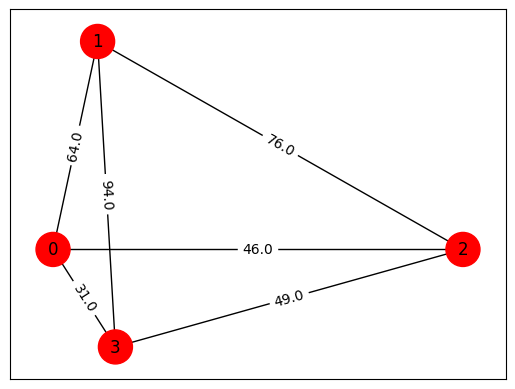

In [5]:
n = 4
vrp = Vrp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(vrp.graph)

print(adj_matrix)

colors = ['r' for node in vrp.graph.nodes]

pos = [vrp.graph.nodes[node]['pos']  for node in vrp.graph.nodes]

draw_graph(vrp.graph, colors, pos)

### Quantum Approximate Optimization Algorithm (QAOA) for VRP

- **Quadratic Program Conversion**: Convert the VRP problem into a quadratic program, which contains the Hamiltonian solved.

In [6]:
qp = vrp.to_quadratic_program()

print(qp.prettyprint())

Problem name: Vehicle routing

Minimize
  64*x_0_1 + 46*x_0_2 + 31*x_0_3 + 64*x_1_0 + 76*x_1_2 + 94*x_1_3 + 46*x_2_0
  + 76*x_2_1 + 49*x_2_3 + 31*x_3_0 + 94*x_3_1 + 49*x_3_2

Subject to
  Linear constraints (12)
    x_1_0 + x_1_2 + x_1_3 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 == 1  'c2'
    x_0_1 + x_2_1 + x_3_1 == 1  'c3'
    x_0_2 + x_1_2 + x_3_2 == 1  'c4'
    x_0_3 + x_1_3 + x_2_3 == 1  'c5'
    x_1_0 + x_2_0 + x_3_0 == 2  'c6'
    x_0_1 + x_0_2 + x_0_3 == 2  'c7'
    x_1_2 + x_2_1 <= 1  'c8'
    x_1_3 + x_3_1 <= 1  'c9'
    x_2_3 + x_3_2 <= 1  'c10'
    x_1_2 + x_1_3 + x_2_1 + x_2_3 + x_3_1 + x_3_2 <= 2  'c11'

  Binary variables (12)
    x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2



### QAOA Implementation with Qiskit

- **Quantum Session Creation**: established a session with the desired quantum backend
- **QAOA Intialization**: set up a QAOA instance using the classical COBYLA optimizer, a default sampler, and the previously defined callback function
- **Optimization Process**: use the optimizer to obtained a linked system, solves the quadratic program with the system and displays the result.

In [7]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    qaoa = QAOA(sampler=Sampler(session=session), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
    qaoa_meo = MinimumEigenOptimizer(qaoa)
    qaoa_result = qaoa_meo.solve(qp)

    print(qaoa_result)

Iteration: 10 , value: (-1270.4262500000013+0j)
Iteration: 20 , value: (93.68450000000044+0j)
fval=248.0, x_0_1=0.0, x_0_2=1.0, x_0_3=1.0, x_1_0=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, status=SUCCESS


### Interpretation of QAOA Results

Use the library to interpret the QAOA result and display the solution

In [8]:
result = vrp.interpret(qaoa_result.x)
print('solution:', result)

solution: [[[0, 2], [2, 1], [1, 0]], [[0, 3], [3, 0]]]


In [9]:
def draw_vrp_solution(G, order, colors, pos):
    """
    Auxiliary function to visualize the final solution of the Vehicle Routing Problem (VRP).
    
    This function creates a directed graph from the original graph and adds directed edges 
    based on the provided order to represent the solution path. Each vehicle's route is 
    represented with a unique color.
    
    Parameters:
    - G (Graph): The original graph representing the VRP.
    - order (list of lists): Each inner list represents the order of nodes for a particular 
                             vehicle's route, with each node represented as a tuple (start, end).
    - colors (list): List of colors for the nodes.
    - pos (list): Positions of the nodes for drawing.
    """
    
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    vColors = ['r', 'g', 'b', 'y']
    
    for i, car in enumerate(order):
        vColor = list(np.random.randint(0, 256, size=3)/256)
        
        for pair in car:
            G2.add_edge(pair[0], pair[1], weight=G[pair[0]][pair[1]]['weight'], color=vColor)
            
    default_axes = plt.axes(frameon=True)
    eColors = nx.get_edge_attributes(G2,'color').values()
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos, edge_color=eColors)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

Draw the final solution of the Vehicle Routing Problem using the QAOA result

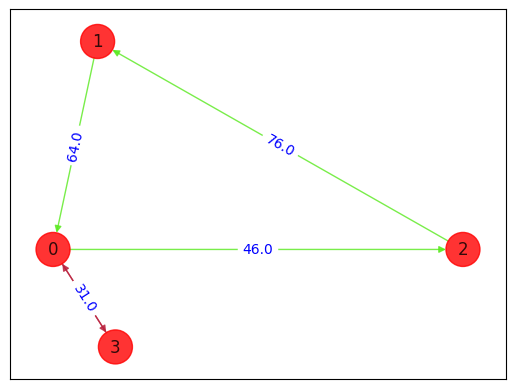

In [10]:
draw_vrp_solution(vrp.graph, result, colors, pos)